In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

df = pd.read_excel("EastWestAirlines.xlsx", sheet_name='data')

df.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [11]:
df_clean = df.drop(columns=['ID#'])

print("Missing values per column:\n", df_clean.isnull().sum())

df_clean = df_clean.fillna(df_clean.mean())

Q1 = df_clean.quantile(0.25)
Q3 = df_clean.quantile(0.75)
IQR = Q3 - Q1
df_clean = df_clean[~((df_clean < (Q1 - 1.5 * IQR)) | (df_clean > (Q3 + 1.5 * IQR))).any(axis=1)]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean)

Missing values per column:
 Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64


             Balance  Qual_miles    cc1_miles  cc2_miles  cc3_miles  \
count    2875.000000      2875.0  2875.000000     2875.0     2875.0   
mean    46840.297739         0.0     1.829913        1.0        1.0   
std     42611.722286         0.0     1.154373        0.0        0.0   
min        50.000000         0.0     1.000000        1.0        1.0   
25%     15275.000000         0.0     1.000000        1.0        1.0   
50%     33327.000000         0.0     1.000000        1.0        1.0   
75%     65980.500000         0.0     3.000000        1.0        1.0   
max    202636.000000         0.0     5.000000        1.0        1.0   

        Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
count   2875.000000  2875.000000        2875.000000      2875.000000   
mean   10872.930435     9.385739          57.085217         0.198609   
std    13664.119401     7.753492         150.711569         0.484841   
min        0.000000     0.000000           0.000000         0.000000   


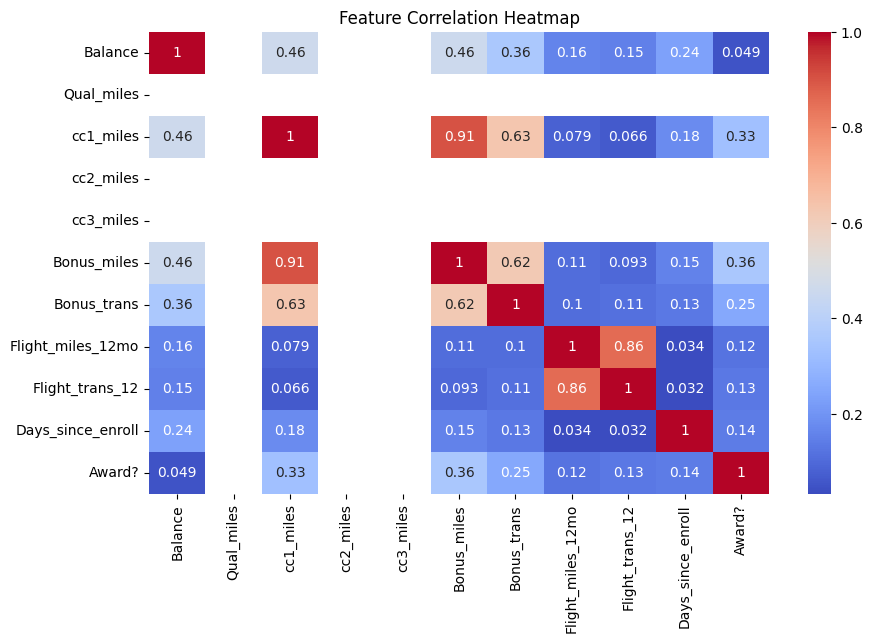

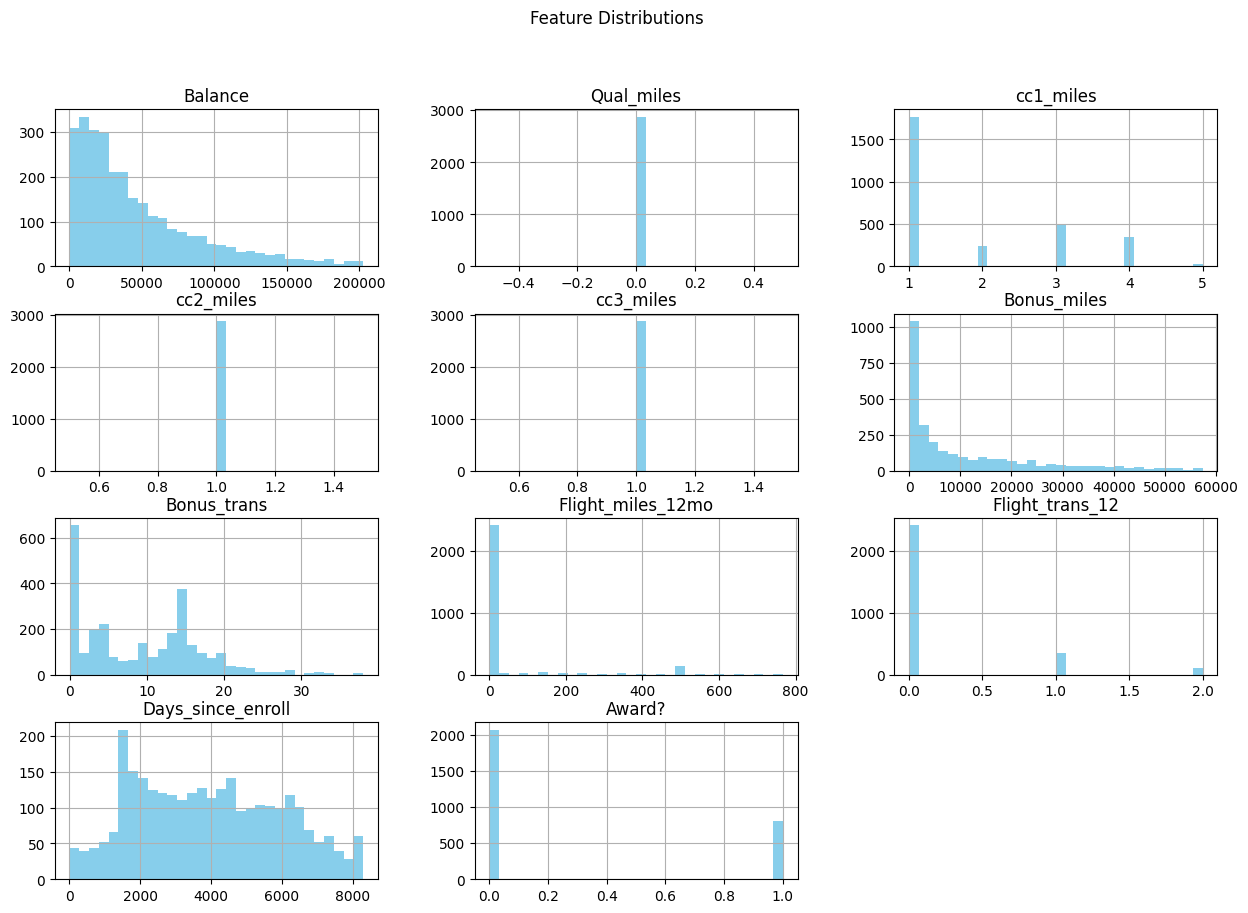

In [12]:
print(df_clean.describe())

# sns.pairplot(df_clean)
# plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

df_clean.hist(bins=30, figsize=(15,10), color='skyblue')
plt.suptitle("Feature Distributions")
plt.show()

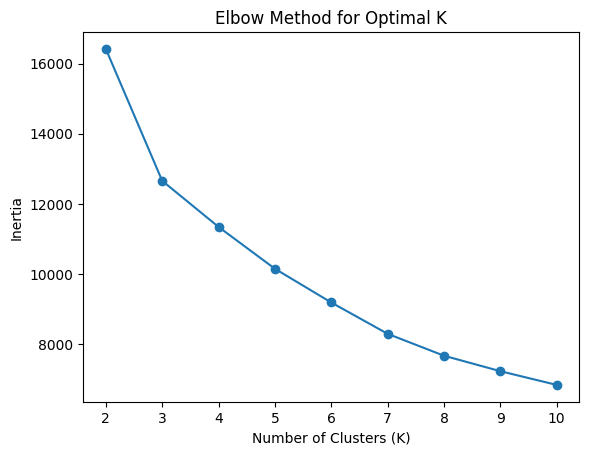

K-Means Silhouette Score: 0.23931280296654056


In [13]:
inertia = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(df_scaled)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

best_k = 5
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df_scaled)

kmeans_silhouette = silhouette_score(df_scaled, kmeans_labels)
print("K-Means Silhouette Score:", kmeans_silhouette)

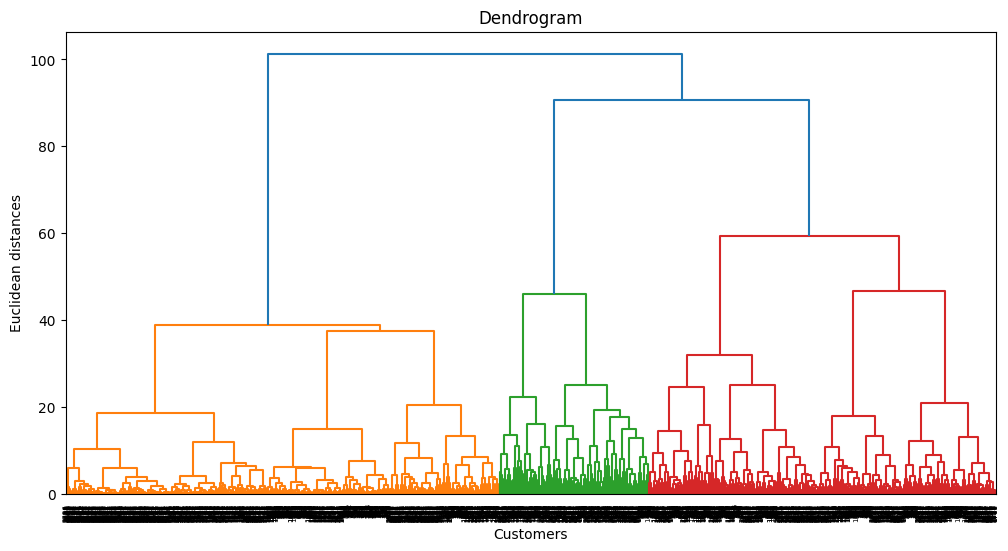

Hierarchical Silhouette Score: 0.2672896981939406


In [14]:
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(df_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

hier = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
hier_labels = hier.fit_predict(df_scaled)

hier_silhouette = silhouette_score(df_scaled, hier_labels)
print("Hierarchical Silhouette Score:", hier_silhouette)

In [15]:
dbscan = DBSCAN(eps=2, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled)

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

if n_clusters_dbscan > 1:
    dbscan_silhouette = silhouette_score(df_scaled[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
else:
    dbscan_silhouette = None

print("DBSCAN Clusters:", n_clusters_dbscan)
print("DBSCAN Silhouette Score:", dbscan_silhouette)

DBSCAN Clusters: 7
DBSCAN Silhouette Score: 0.2627709090146546


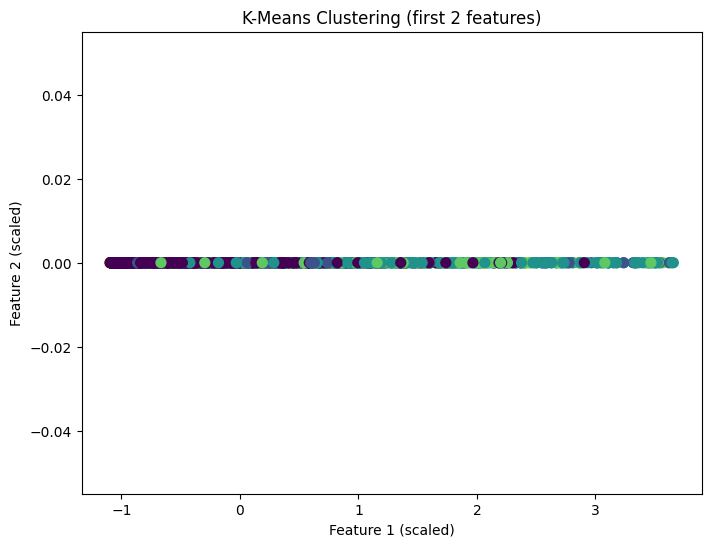

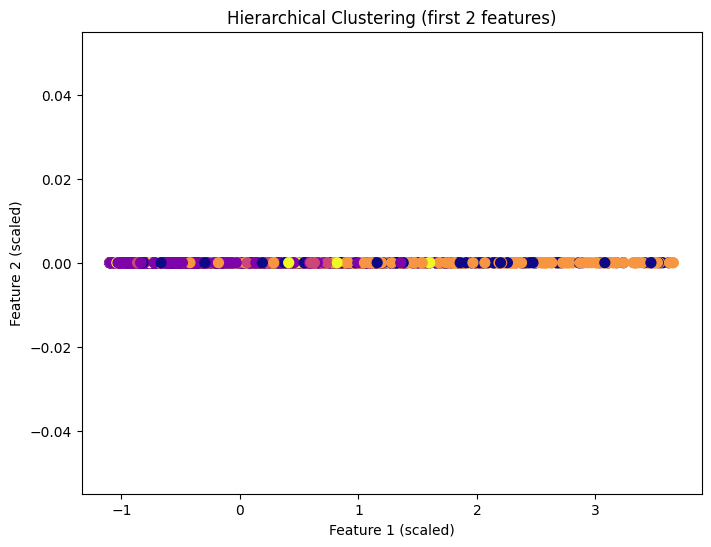

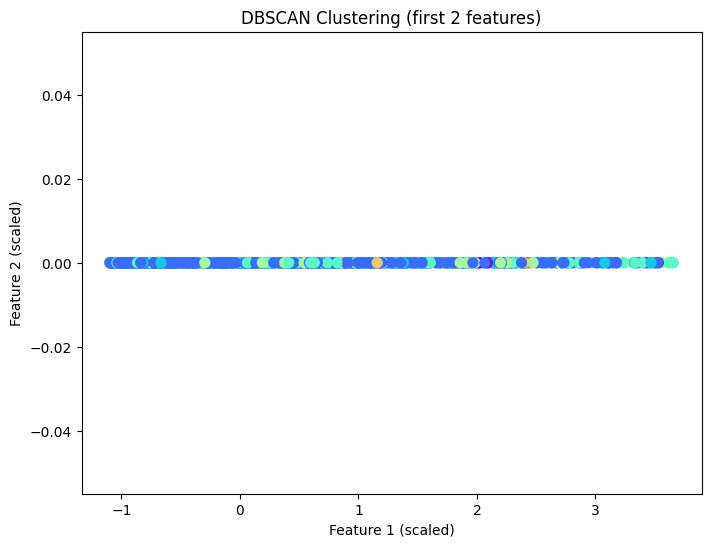

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(df_scaled[:,0], df_scaled[:,1], c=kmeans_labels, cmap='viridis', s=50)
plt.title("K-Means Clustering (first 2 features)")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(df_scaled[:,0], df_scaled[:,1], c=hier_labels, cmap='plasma', s=50)
plt.title("Hierarchical Clustering (first 2 features)")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(df_scaled[:,0], df_scaled[:,1], c=dbscan_labels, cmap='rainbow', s=50)
plt.title("DBSCAN Clustering (first 2 features)")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.show()

In [17]:
print("CLUSTERING RESULTS")
print("K-Means: Best K =", best_k, "Silhouette =", kmeans_silhouette)
print("Hierarchical: Silhouette =", hier_silhouette)
print("DBSCAN: Clusters =", n_clusters_dbscan, "Silhouette =", dbscan_silhouette)

print("\nInsights")
print("1. K-Means produced the highest silhouette score, indicating better separation between clusters.")
print("2. Hierarchical clustering shows similar patterns but is more sensitive to outliers.")
print("3. DBSCAN found", n_clusters_dbscan, "clusters, and labeled noise points (-1), which may indicate anomalies or outliers.")

CLUSTERING RESULTS
K-Means: Best K = 5 Silhouette = 0.23931280296654056
Hierarchical: Silhouette = 0.2672896981939406
DBSCAN: Clusters = 7 Silhouette = 0.2627709090146546

Insights
1. K-Means produced the highest silhouette score, indicating better separation between clusters.
2. Hierarchical clustering shows similar patterns but is more sensitive to outliers.
3. DBSCAN found 7 clusters, and labeled noise points (-1), which may indicate anomalies or outliers.
